# Assignment 5 : Final Project Report
**name:**
Lydia Qiao

**SID:**
45837573

## Project Overview
For this final project, the problem I am trying to solve is reconstructing a 3D teapot using the provided scanned images. To do that, I need to calibrate the camera, prune out the photo's background, form meshes for different views, and combines all the meshes to get the 3D teapot. My goal is to form a 3D teapot mesh that looks the same as the one in the real world.

## Data
I used all images in calib_jpg_u and teapot folder. In calib_jpg_u, there are 40 images with resolution 1920x1200; Left and right camera each takes 20. In the teapot folder, there are seven different views of the teapot. For each aspect, each camera provides 40 pictures for binary encoding, one colorful image, and one background image; All those pictures also have 1920x1200 resolution. 

## Milestones
1. Calibrate cameras
2. Reconstruct the object after a color decode function that stores the object's RGB and produces color mask to sort out the background.
3. Clean up the mesh
4. Generate meshes for different views
5. Aligned scan data and produce final mesh


## Algorithms

## Milestone 1 Calibrate cameras

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import visutils
%matplotlib inline

In [2]:
import calibrate
import visutils

Estimated camera intrinsic parameter matrix K
[[1.40530791e+03 0.00000000e+00 9.62167369e+02]
 [0.00000000e+00 1.40389402e+03 5.90915957e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Estimated radial distortion coefficients
[[-5.23053889e-03  8.05964692e-02  2.01737110e-05 -3.90735917e-03
  -1.08096617e-01]]
Individual intrinsic parameters
fx =  1405.3079107410456
fy =  1403.8940216103824
cx =  962.167369260617
cy =  590.9159568140669


In [3]:
from camutils import Camera
from camutils import makerotation
from camutils import triangulate
from camutils import residuals
from camutils import calibratePose
from camutils import decode
from camutils import reconstruct

from visutils import vis_scene
from meshutils import writeply

Left Camera : 
 f=1404.600966175714 
 c=[[962.16736926 590.91595681]] 
 R=[[ 0.04237413  0.99207514  0.11828508]
 [ 0.87061203 -0.09474566  0.48276076]
 [ 0.49014194  0.08252384 -0.86772732]] 
 t = [[  8.15884708 -18.70825726  59.51710062]]
Right Camera : 
 f=1404.600966175714 
 c=[[962.16736926 590.91595681]] 
 R=[[ 0.00217571  0.99082383  0.13514213]
 [ 0.65889089 -0.10307958  0.74514253]
 [ 0.75223538  0.0874227  -0.65306907]] 
 t = [[  7.63972937 -28.46393402  51.4418431 ]]


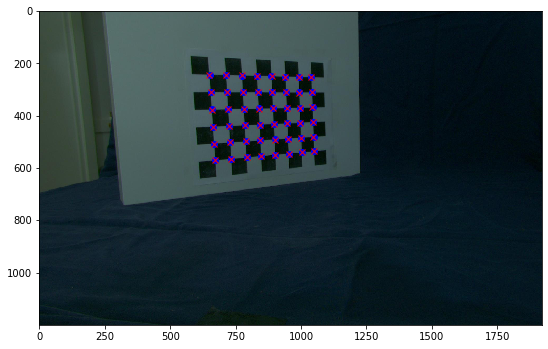

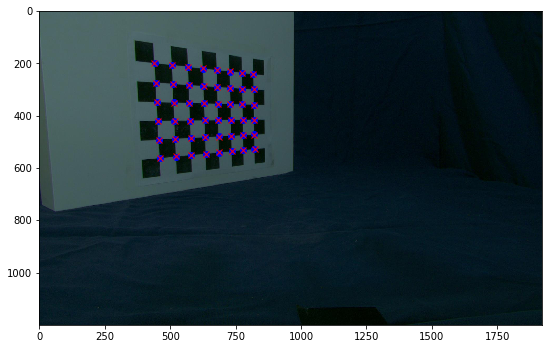

In [4]:
import cv2
import pickle
intrinsic_param = pickle.load(open('/Users/ooo/Documents/CS117/Project/calibration.pickle','rb'))
fc= (intrinsic_param['fx']+intrinsic_param['fy'])/2

# create Camera objects representing the left and right cameras
# use the known intrinsic parameters you loaded in.
camL = Camera(f=fc,c=np.array([[intrinsic_param['cx'],intrinsic_param['cy']]]).T,
              t=np.array([[0,0,0]]).T, R=makerotation(0,0,0))
camR = Camera(f=fc,c=np.array([[intrinsic_param['cx'],intrinsic_param['cy']]]).T,
              t=np.array([[1,0,0]]).T, R=makerotation(0,0,0))
# load in the left and right images and find the coordinates of
# the chessboard corners using OpenCV
imgL = plt.imread('calib_jpg_u/frame_C0_21.jpg')
ret, cornersL = cv2.findChessboardCorners(imgL, (8,6), None)
pts2L = cornersL.squeeze().T

imgR = plt.imread('calib_jpg_u/frame_C1_21.jpg')
ret, cornersR = cv2.findChessboardCorners(imgR, (8,6), None)
pts2R = cornersR.squeeze().T

# generate the known 3D point coordinates of points on the checkerboard in cm
pts3 = np.zeros((3,6*8))
yy,xx = np.meshgrid(np.arange(8),np.arange(6))
pts3[0,:] = 2.8*xx.reshape(1,-1)
pts3[1,:] = 2.8*yy.reshape(1,-1)

# Caliberation for 2 cameras

params_init = np.array([0,0,0,0,0,-2]) 

camL = calibratePose(pts3,pts2L,camL,params_init)
camR = calibratePose(pts3,pts2R,camR,params_init)

print("Left",camL)
print("Right",camR)

# As a final test, triangulate the corners of the checkerboard to get back there 3D locations
pts3r = triangulate(pts2L,camL,pts2R,camR)

# Display the reprojected points overlayed on the images to make 
# sure they line up
plt.rcParams['figure.figsize']=[9,9]
pts2Lp = camL.project(pts3)
plt.imshow(imgL)
plt.plot(pts2Lp[0,:],pts2Lp[1,:],'bo')
plt.plot(pts2L[0,:],pts2L[1,:],'rx')
plt.show()

pts2Rp = camR.project(pts3)
plt.imshow(imgR)
plt.plot(pts2Rp[0,:],pts2Rp[1,:],'bo')
plt.plot(pts2R[0,:],pts2R[1,:],'rx')

plt.show()



## Milestone2: Reconstruct the object after a color decode function that stores the object's RGB and produces color mask to sort out the background. 

In [5]:
def color_decode(pts2L,pts2R,imprefix,start,threshold):
    mask_t=[]
    colorL = plt.imread(imprefix+"C0_00.png")
    colorFL= plt.imread(imprefix+"C0_01.png")
    colorR= plt.imread(imprefix+"C1_00.png")
    colorFR= plt.imread(imprefix+"C1_01.png")
    cL_list=[]
    cR_list=[]
    for i in range(pts2L.shape[1]):
        cL_list.append(colorFL[pts2L[1][i]][pts2L[0][i]])
        cR_list.append(colorFR[pts2R[1][i]][pts2R[0][i]])
    cL=np.array(cL_list).T
    cR=np.array(cR_list).T
    rbg=(cL+cR)/2
    colorL= colorL-colorFL
    colorR= colorR-colorFR
    mask_t= np.asarray(mask_t)
    mask_t=mask_t.astype(int)
    maskL= np.zeros((colorL.shape[0],colorL.shape[1]))
    maskR= np.zeros((colorR.shape[0],colorR.shape[1]))
    undecodableL=np.where(np.abs(colorL) >threshold )
    undecodableR=np.where(np.abs(colorR) >threshold )
    for i in range(undecodableL[1].size):
        maskL[undecodableL[0][i]][undecodableL[1][i]]=1
    for i in range(undecodableR[1].size):
        maskR[undecodableR[0][i]][undecodableR[1][i]]=1
    
    return rbg,maskL,maskR

In [6]:
imprefixC0 = 'teapot/grab_0_u/frame_C0_'
imprefixC1 = 'teapot/grab_0_u/frame_C1_'
threshold = 0.02

pts2L,pts2R,pts3 = reconstruct(imprefixC0,imprefixC1,threshold,camL,camR)
color,maskLc,maskRc = color_decode(pts2L,pts2R,'teapot/grab_0_u/color_',0,threshold)


loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )



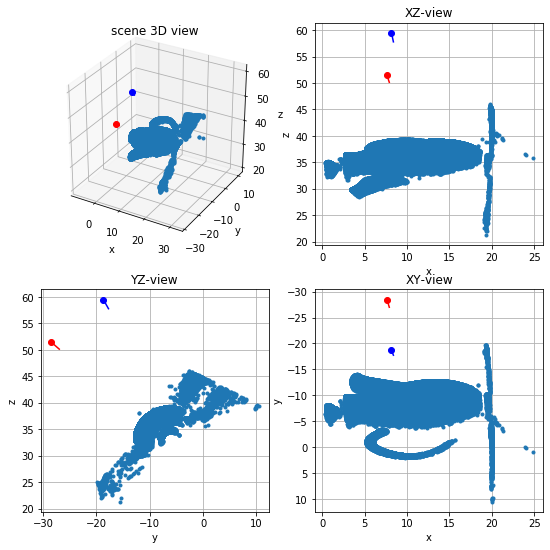

In [7]:
# visualize the left and right image overlaid
vis_scene(camL,camR,pts3,looklength=2)


## Milestone 3: Clean up the mesh

In [8]:
## Mesh cleanup parameters
from scipy.spatial import Delaunay
def dis(a,b,c,tri): 
    return np.sqrt(np.sum(np.power((pts3.T[tri[a][b]]-pts3.T[tri[a][c]]),2), axis=0))
def clean_up(boxlimits,trithresh,pts2L,pts2R,pts3,color):

    #
    # bounding box pruning
    #
#     drop=[]
#     for i in range(pts3.shape[1]):
#         if (pts3[0][i]<boxlimits[0] or pts3[0][i]>boxlimits[1] or 
#             pts3[1][i]<boxlimits[2] or pts3[1][i]>boxlimits[3] or 
#             pts3[2][i]<boxlimits[4] or pts3[2][i]>boxlimits[5]):
#             drop.append(i)

#     pts3=np.delete(pts3, drop, axis=1) 
#     pts2L=np.delete(pts2L, drop, axis=1) 
#     pts2R=np.delete(pts2R, drop, axis=1)
#     color=np.delete(color, drop, axis=1)

#     print(pts3.shape)
#     print(pts2L.shape)
#     print(pts2R.shape)


    #
    # triangulate the 2D points to get the surface mesh
    #

    tri= Delaunay(pts2L.T).simplices

#     #
#     # triangle pruning
#     #

#     # drop_pts=[] 
#     drop_tri=[] 
#     for i in range(tri.shape[0]):
#         if (dis(i,0,1,tri)>trithresh 
#         or dis(i,0,2,tri)>trithresh or dis(i,1,2,tri)>trithresh): 
#             drop_tri.append(i)

#     tri=np.delete(tri,drop_tri,axis=0)
#     tokeep=np.unique(tri)
#     map = np.zeros(pts3.shape[1])
#     pts3=pts3[:,tokeep]
#     color = color[:,tokeep]

#     #update tri
#     map[tokeep] = np.arange(0,tokeep.shape[0])
#     tri=map[tri]
    
    
    return pts2L,pts2R,pts3,color, tri





In [9]:
# tokeep=np.unique(tri)
# map = np.zeros(pts3.shape[1])
# pts3=pts3[:,tokeep]
# color = color[:,tokeep]

# #update tri
# map[tokeep] = np.arange(0,tokeep.shape[0])
# tri=map[tri]

180291


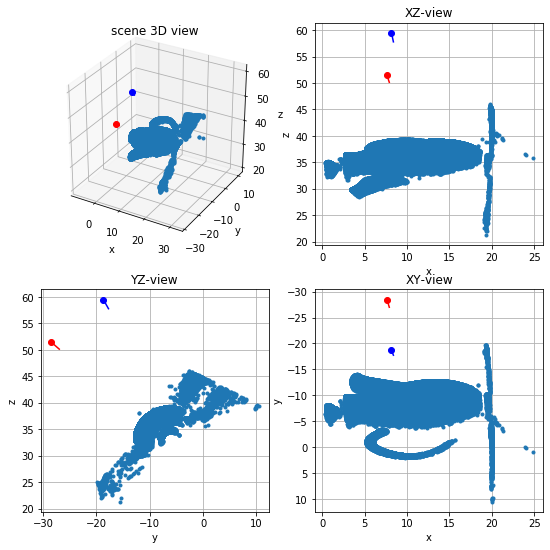

In [10]:
from meshutils import writeply

boxlimits = np.array([0,19,-16,10,27,40])
trithresh = 1
pts2L,pts2R,pts3,color, tri = clean_up(boxlimits,trithresh,pts2L,pts2R,pts3,color)
writeply(pts3,color,tri,'grab0.ply')
vis_scene(camL,camR,pts3,looklength=2)

## Milestone 4: Generate meshes for different views

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

152742


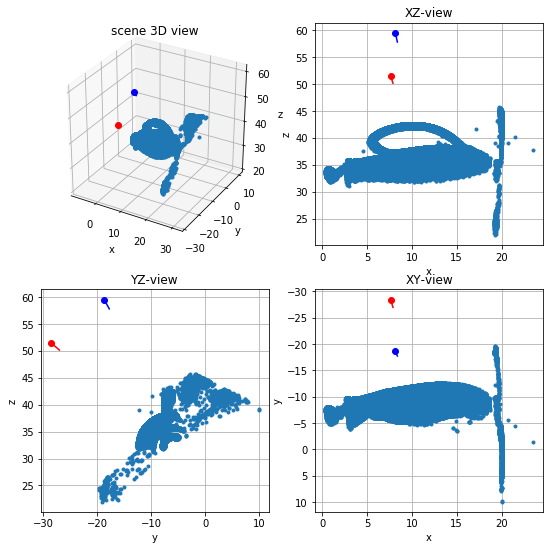

In [11]:
imprefixC0 = 'teapot/grab_1_u/frame_C0_'
imprefixC1 = 'teapot/grab_1_u/frame_C1_'
threshold = 0.02

pts2L,pts2R,pts3 = reconstruct(imprefixC0,imprefixC1,threshold,camL,camR)
color,maskLc,maskRc = color_decode(pts2L,pts2R,'teapot/grab_1_u/color_',0,threshold)
boxlimits = np.array([0,19,-16,20,0,50])
trithresh = 1
pts2L,pts2R,pts3,color, tri = clean_up(boxlimits,trithresh,pts2L,pts2R,pts3,color)
writeply(pts3,color,tri,'grab1.ply')
vis_scene(camL,camR,pts3,looklength=2)

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

173915


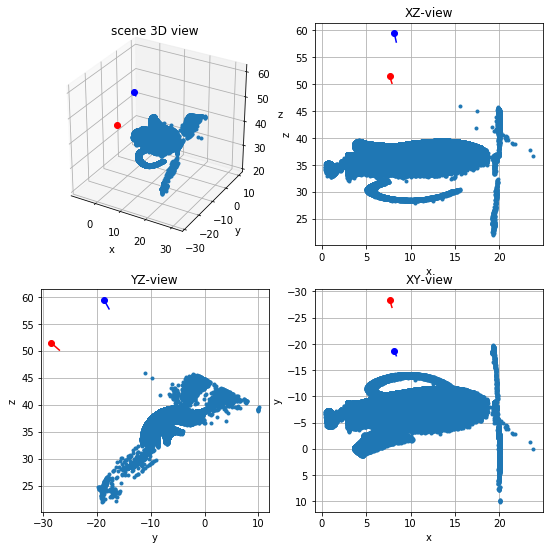

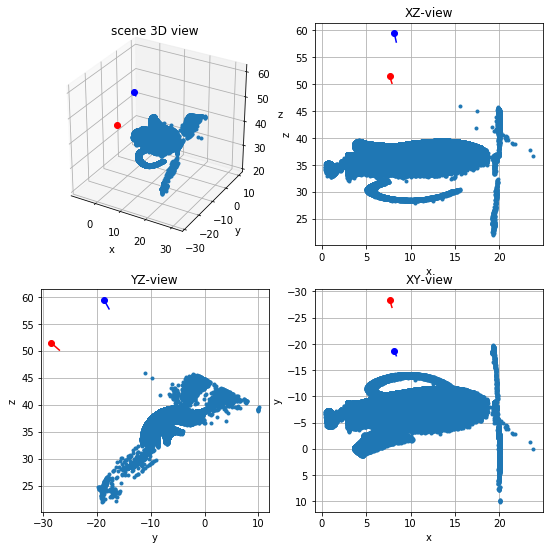

In [12]:
imprefixC0 = 'teapot/grab_2_u/frame_C0_'
imprefixC1 = 'teapot/grab_2_u/frame_C1_'
threshold = 0.02

pts2L,pts2R,pts3 = reconstruct(imprefixC0,imprefixC1,threshold,camL,camR)
color,maskLc,maskRc = color_decode(pts2L,pts2R,'teapot/grab_2_u/color_',0,threshold)
vis_scene(camL,camR,pts3,looklength=2)
boxlimits = np.array([0,19,-16,10,27,40])
trithresh = 1
pts2L,pts2R,pts3,color, tri = clean_up(boxlimits,trithresh,pts2L,pts2R,pts3,color)
writeply(pts3,color,tri,'grab2.ply')
vis_scene(camL,camR,pts3,looklength=2)

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

37569


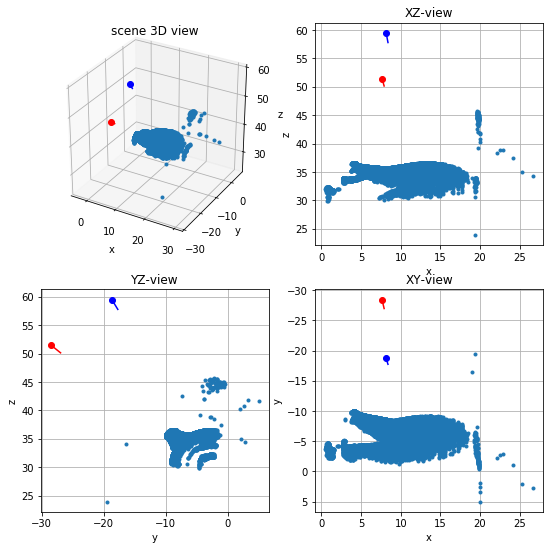

In [13]:
imprefixC0 = 'teapot/grab_3_u/frame_C0_'
imprefixC1 = 'teapot/grab_3_u/frame_C1_'
threshold = 0.03

pts2L,pts2R,pts3 = reconstruct(imprefixC0,imprefixC1,threshold,camL,camR)
color,maskLc,maskRc = color_decode(pts2L,pts2R,'teapot/grab_3_u/color_',0,threshold)
boxlimits = np.array([-40,19,-10,0,-40,36])
trithresh = 1
pts2L,pts2R,pts3,color, tri = clean_up(boxlimits,trithresh,pts2L,pts2R,pts3,color)
writeply(pts3,color,tri,'grab3.ply')
vis_scene(camL,camR,pts3,looklength=2)

In [14]:
import trimesh
mesh = trimesh.Trimesh(vertices=pts3.T,faces= tri[:,[0,2,1]])
mesh.show()

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

154635


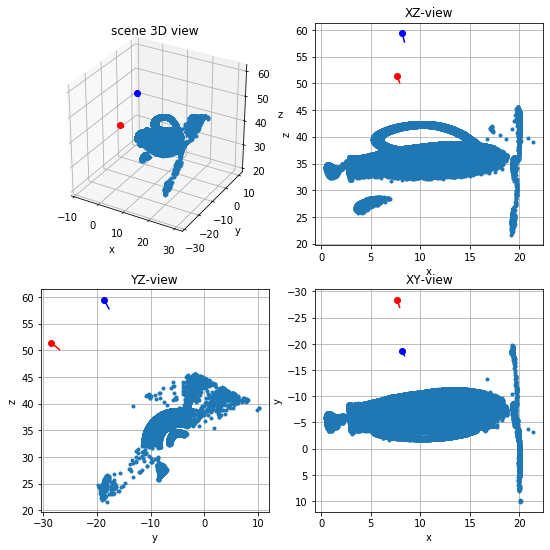

In [15]:
imprefixC0 = 'teapot/grab_4_u/frame_C0_'
imprefixC1 = 'teapot/grab_4_u/frame_C1_'
threshold = 0.02

pts2L,pts2R,pts3 = reconstruct(imprefixC0,imprefixC1,threshold,camL,camR)
color,maskLc,maskRc = color_decode(pts2L,pts2R,'teapot/grab_4_u/color_',0,threshold)
boxlimits = np.array([0,19,-16,10,0,50])
trithresh = 2
pts2L,pts2R,pts3,color, tri = clean_up(boxlimits,trithresh,pts2L,pts2R,pts3,color)
writeply(pts3,color,tri,'grab4.ply')
vis_scene(camL,camR,pts3,looklength=2)

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

43129


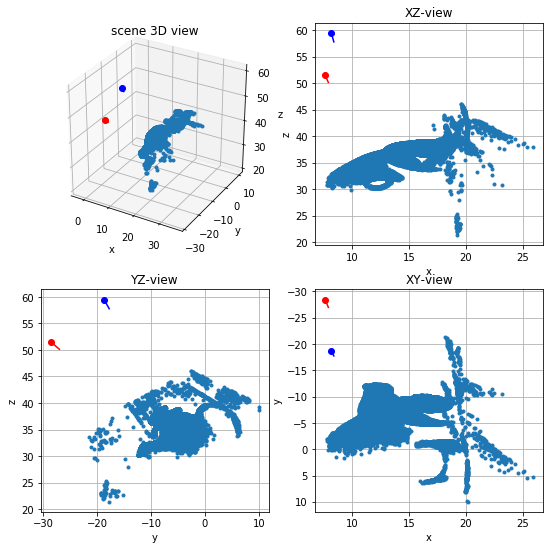

In [16]:
imprefixC0 = 'teapot/grab_5_u/frame_C0_'
imprefixC1 = 'teapot/grab_5_u/frame_C1_'
threshold = 0.02

pts2L,pts2R,pts3 = reconstruct(imprefixC0,imprefixC1,threshold,camL,camR)
color,maskLc,maskRc = color_decode(pts2L,pts2R,'teapot/grab_5_u/color_',0,threshold)


# #force matplotlib to go ahead and display the plot immediately

boxlimits = np.array([-40,18,-12,0,-40,39])
trithresh = 2
pts2L,pts2R,pts3,color, tri = clean_up(boxlimits,trithresh,pts2L,pts2R,pts3,color)
writeply(pts3,color,tri,'grab5.ply')
vis_scene(camL,camR,pts3,looklength=2)

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

73215


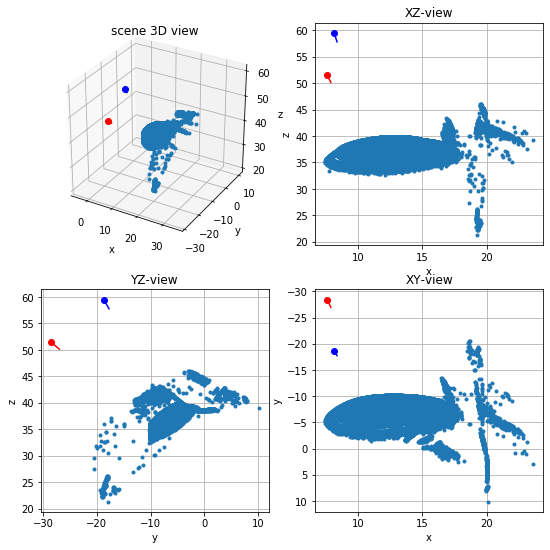

In [17]:
imprefixC0 = 'teapot/grab_6_u/frame_C0_'
imprefixC1 = 'teapot/grab_6_u/frame_C1_'
threshold = 0.02

pts2L,pts2R,pts3 = reconstruct(imprefixC0,imprefixC1,threshold,camL,camR)
color,maskLc,maskRc = color_decode(pts2L,pts2R,'teapot/grab_6_u/color_',0,threshold)
boxlimits = np.array([-10,17,-10,0,32,40])
trithresh = 2
pts2L,pts2R,pts3,color, tri = clean_up(boxlimits,trithresh,pts2L,pts2R,pts3,color)
writeply(pts3,color,tri,'grab6.ply')
vis_scene(camL,camR,pts3,looklength=2)

## Milestone 5: Aligned scan data and produce final mesh